In [1]:
import os
import json
import gzip
import requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
def download_nvd_feed(year):
    feed_url = f'https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{year}.json.gz'
    response = requests.get(feed_url)

    with open(f'nvdcve-1.1-{year}.json.gz', 'wb') as f:
        f.write(response.content)

    return f'nvdcve-1.1-{year}.json.gz'


In [3]:
def extract_cve_from_item(item):
    if 'baseMetricV3' not in item['impact']:
        return None

    en_text = next(
        (desc['value'] for desc in item['cve']['description']['description_data']
         if desc['lang'] == 'en'), None)
    if en_text is None:
        return None

    en_text = en_text.replace('\n', ' ')

    return {
        'english_description': en_text,
        'cvssv3_attack_vector': item['impact']['baseMetricV3']['cvssV3']['attackVector'],
        'cvssv3_attack_complexity': item['impact']['baseMetricV3']['cvssV3']['attackComplexity'],
        'cvssv3_privileges_required': item['impact']['baseMetricV3']['cvssV3']['privilegesRequired'],
        'cvssv3_user_interaction': item['impact']['baseMetricV3']['cvssV3']['userInteraction'],
        'cvssv3_scope': item['impact']['baseMetricV3']['cvssV3']['scope'],
        'cvssv3_confidentiality_impact': item['impact']['baseMetricV3']['cvssV3']['confidentialityImpact'],
        'cvssv3_integrity_impact': item['impact']['baseMetricV3']['cvssV3']['integrityImpact'],
        'cvssv3_availability_impact': item['impact']['baseMetricV3']['cvssV3']['availabilityImpact'],
    }

In [4]:
def process_cve_data(years):
    all_cves = []
    skipped = 0
    processed = 0

    for year in years:
        filename = f'nvdcve-1.1-{year}.json.gz'

        if not os.path.exists(filename):
            print(f"Downloading data for year {year}...")
            filename = download_nvd_feed(year)
        else:
            print(f"File for year {year} already exists, using the existing file.")

        with gzip.open(filename, 'rt', encoding='utf-8') as f:
            nvd_data = json.load(f)

        print(f"Processing data for year {year}: {len(nvd_data['CVE_Items'])} total CVEs")

        year_cves = []
        for item in nvd_data['CVE_Items']:
            relevant_data = extract_cve_from_item(item)
            if relevant_data is None:
                skipped += 1
            else:
                year_cves.append(relevant_data)
                processed += 1

        all_cves.extend(year_cves)

    print(f"Processed CVEs: {processed}\nSkipped CVEs: {skipped}")
    return pd.DataFrame(all_cves)


In [5]:
years = [2022, 2023, 2024]
cvss_data = process_cve_data(years)

# Membuat kolom english_description diawali dengan tanda kutip 
cvss_data['english_description'] = cvss_data['english_description'].apply(lambda x: f'"{x}"')

# CLEANING : Ganti semua newline dengan spasi di kolom 'english_description'
cvss_data['english_description'] = cvss_data['english_description'].str.replace(r'[\n\r]+', ' ', regex=True)

# Membuat direktori 'data' jika belum ada
if not os.path.exists('data'):
    os.makedirs('data')

# Simpan data ke dalam file CSV jika diperlukan
cvss_data.to_csv('data/cvss_data.csv', index=False)

File for year 2022 already exists, using the existing file.
Processing data for year 2022: 25287 total CVEs
File for year 2023 already exists, using the existing file.
Processing data for year 2023: 29080 total CVEs
File for year 2024 already exists, using the existing file.
Processing data for year 2024: 32975 total CVEs
Processed CVEs: 60401
Skipped CVEs: 26941


In [6]:
print(cvss_data.describe(include='all'))

                                      english_description  \
count                                               60401   
unique                                              57506   
top     "Adobe Experience Manager versions 6.5.20 and ...   
freq                                                  101   

       cvssv3_attack_vector cvssv3_attack_complexity  \
count                 60401                    60401   
unique                    4                        2   
top                 NETWORK                      LOW   
freq                  44436                    58320   

       cvssv3_privileges_required cvssv3_user_interaction cvssv3_scope  \
count                       60401                   60401        60401   
unique                          3                       2            2   
top                          NONE                    NONE    UNCHANGED   
freq                        32824                   40301        48335   

       cvssv3_confidentiality_impact cvssv

In [7]:
print(cvss_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60401 entries, 0 to 60400
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   english_description            60401 non-null  object
 1   cvssv3_attack_vector           60401 non-null  object
 2   cvssv3_attack_complexity       60401 non-null  object
 3   cvssv3_privileges_required     60401 non-null  object
 4   cvssv3_user_interaction        60401 non-null  object
 5   cvssv3_scope                   60401 non-null  object
 6   cvssv3_confidentiality_impact  60401 non-null  object
 7   cvssv3_integrity_impact        60401 non-null  object
 8   cvssv3_availability_impact     60401 non-null  object
dtypes: object(9)
memory usage: 4.1+ MB
None


In [8]:
print(cvss_data.head)

<bound method NDFrame.head of                                      english_description cvssv3_attack_vector  \
0      "Non-transparent sharing of branch predictor s...                LOCAL   
1      "Non-transparent sharing of branch predictor w...                LOCAL   
2      "Hardware debug modes and processor INIT setti...             PHYSICAL   
3      "Sensitive information accessible by physical ...             PHYSICAL   
4      "Insertion of Sensitive Information into Log F...                LOCAL   
...                                                  ...                  ...   
60396  "Enterprise Cloud Database from Ragic does not...              NETWORK   
60397  "A vulnerability was found in code-projects Bl...              NETWORK   
60398  "A post-authentication SQL Injection vulnerabi...              NETWORK   
60399  "A maliciously crafted DWG file when parsed in...                LOCAL   
60400  "A maliciously crafted DWG file when parsed in...                LOCAL  

In [9]:
print("\nUnique Values per Column:")
print(cvss_data.nunique())


Unique Values per Column:
english_description              57506
cvssv3_attack_vector                 4
cvssv3_attack_complexity             2
cvssv3_privileges_required           3
cvssv3_user_interaction              2
cvssv3_scope                         2
cvssv3_confidentiality_impact        3
cvssv3_integrity_impact              3
cvssv3_availability_impact           3
dtype: int64


In [10]:
# Missing values per kolom
print("\nMissing Values per Column:")
print(cvss_data.isnull().sum())

# Persentase missing values
missing_percentage = cvss_data.isnull().mean() * 100
print("\nPercentage of Missing Values:")
print(missing_percentage)


Missing Values per Column:
english_description              0
cvssv3_attack_vector             0
cvssv3_attack_complexity         0
cvssv3_privileges_required       0
cvssv3_user_interaction          0
cvssv3_scope                     0
cvssv3_confidentiality_impact    0
cvssv3_integrity_impact          0
cvssv3_availability_impact       0
dtype: int64

Percentage of Missing Values:
english_description              0.0
cvssv3_attack_vector             0.0
cvssv3_attack_complexity         0.0
cvssv3_privileges_required       0.0
cvssv3_user_interaction          0.0
cvssv3_scope                     0.0
cvssv3_confidentiality_impact    0.0
cvssv3_integrity_impact          0.0
cvssv3_availability_impact       0.0
dtype: float64


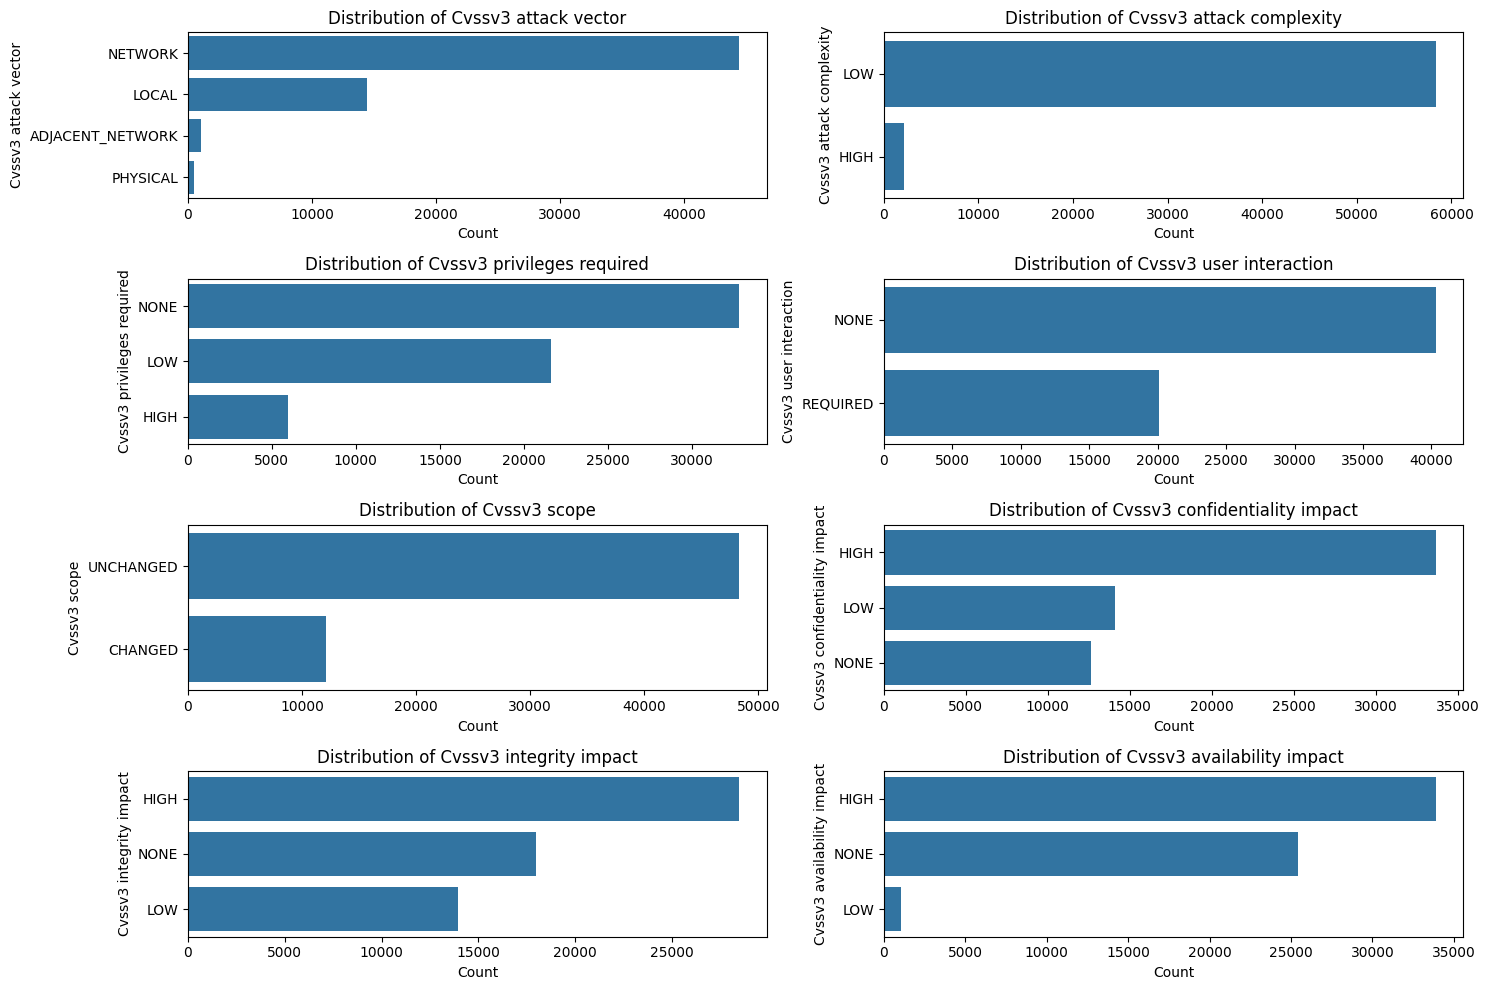

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasi distribusi per kategori
categories = [
    'cvssv3_attack_vector', 'cvssv3_attack_complexity', 'cvssv3_privileges_required',
    'cvssv3_user_interaction', 'cvssv3_scope', 'cvssv3_confidentiality_impact',
    'cvssv3_integrity_impact', 'cvssv3_availability_impact'
]

plt.figure(figsize=(15, 10))
for i, category in enumerate(categories):
    plt.subplot(4, 2, i + 1)
    sns.countplot(y=category, data=cvss_data, order=cvss_data[category].value_counts().index)
    plt.title(f"Distribution of {category.replace('_', ' ').capitalize()}")
    plt.xlabel('Count')
    plt.ylabel(category.replace('_', ' ').capitalize())

plt.tight_layout()
plt.show()


In [12]:
print(cvss_data.shape)

(60401, 9)


In [13]:
# Distribusi setiap kategori
for category in categories:
    print(f"\nDistribusi untuk {category}:")
    print(cvss_data[category].value_counts(normalize=True) * 100)


Distribusi untuk cvssv3_attack_vector:
cvssv3_attack_vector
NETWORK             73.568318
LOCAL               23.839009
ADJACENT_NETWORK     1.710237
PHYSICAL             0.882436
Name: proportion, dtype: float64

Distribusi untuk cvssv3_attack_complexity:
cvssv3_attack_complexity
LOW     96.554693
HIGH     3.445307
Name: proportion, dtype: float64

Distribusi untuk cvssv3_privileges_required:
cvssv3_privileges_required
NONE    54.343471
LOW     35.762653
HIGH     9.893876
Name: proportion, dtype: float64

Distribusi untuk cvssv3_user_interaction:
cvssv3_user_interaction
NONE        66.722405
REQUIRED    33.277595
Name: proportion, dtype: float64

Distribusi untuk cvssv3_scope:
cvssv3_scope
UNCHANGED    80.02351
CHANGED      19.97649
Name: proportion, dtype: float64

Distribusi untuk cvssv3_confidentiality_impact:
cvssv3_confidentiality_impact
HIGH    55.717621
LOW     23.357229
NONE    20.925150
Name: proportion, dtype: float64

Distribusi untuk cvssv3_integrity_impact:
cvssv3_integr

count    60401.000000
mean       327.763564
std        327.911228
min         23.000000
25%        162.000000
50%        251.000000
75%        393.000000
max       4000.000000
Name: description_length, dtype: float64


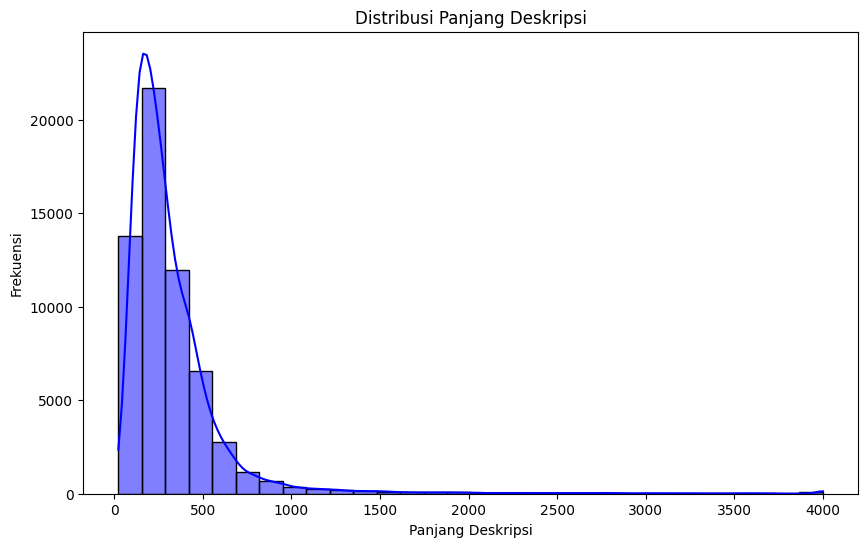

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung panjang teks
cvss_data['description_length'] = cvss_data['english_description'].apply(len)

# Statistik deskriptif
length_stats = cvss_data['description_length'].describe()
print(length_stats)

# Visualisasi distribusi panjang teks
plt.figure(figsize=(10, 6))
sns.histplot(cvss_data['description_length'], kde=True, bins=30, color='blue')
plt.title('Distribusi Panjang Deskripsi')
plt.xlabel('Panjang Deskripsi')
plt.ylabel('Frekuensi')
plt.show()

count    60401.000000
mean        46.909985
std         42.027848
min          2.000000
25%         23.000000
50%         37.000000
75%         58.000000
max        638.000000
Name: word_count, dtype: float64


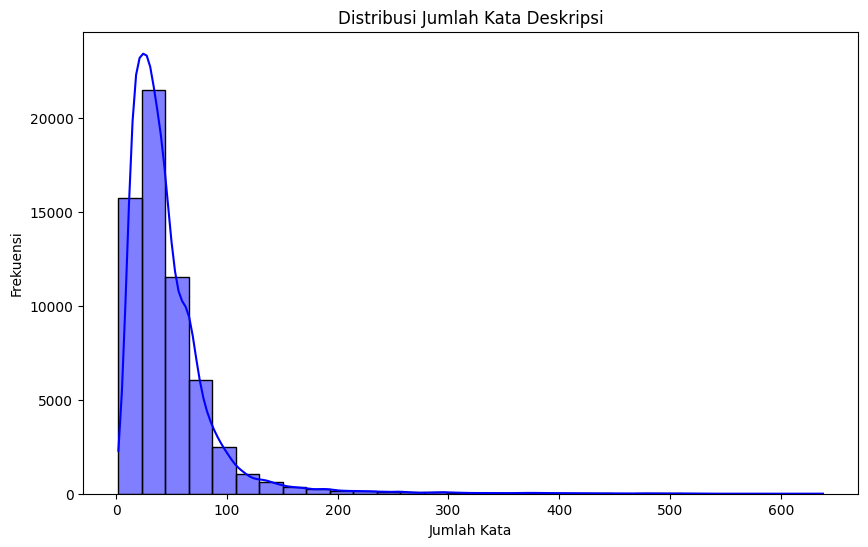

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate word count and add it as a new column
cvss_data['word_count'] = cvss_data['english_description'].apply(lambda x: len(x.split()))

# Statistik deskriptif
length_stats = cvss_data['word_count'].describe()
print(length_stats)

# Visualisasi distribusi panjang teks
plt.figure(figsize=(10, 6))
sns.histplot(cvss_data['word_count'], kde=True, bins=30, color='blue')
plt.title('Distribusi Jumlah Kata Deskripsi')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()